# Assignment 3: Amazon Reviews Star Rating
BBM 409 - Machine Learning Laboratory, Spring 2025  
**Names:** [Zeynep Nisa Karataş, Gül Sena Ergun]  
**Student IDs:** [2210356066, 2210356113]

This notebook presents a complete implementation of sentiment classification using a Multinomial Naive Bayes algorithm and a Bag of Words (BoW) representation, both developed from scratch. The dataset used consists of Amazon product reviews that include a star rating, title, and content. The objective is to classify these reviews into binary sentiment classes: positive or negative.

The notebook progresses through the following stages:
- Data loading and exploration
- Text preprocessing (cleaning and tokenization)
- Manual sentiment labeling based on star ratings
- Feature extraction using BoW for unigrams and bigrams
- Naive Bayes classifier training and evaluation
- Bonus experiment using Word2Vec + Logistic Regression

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
import re
import math

In [62]:
# Print versions of key libraries used in this notebook
print("Library Versions:")
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("seaborn:", sns.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)
import gensim
print("gensim:", gensim.__version__)

Library Versions:
pandas: 2.2.2
numpy: 1.26.4
matplotlib: 3.9.2
seaborn: 0.13.2
scikit-learn: 1.5.1
gensim: 4.3.3


In [8]:
# Load the CSV dataset that contains product reviews with star ratings, titles and content.
file_path = 'amazon_reviews.csv'
df = pd.read_csv(file_path)

In [10]:
df.head()

,Title,Content,Star
0,Didn't work,No change in nails at all.,1.0
1,Worst nail product I have ever used.,Garbage! Do not waste your $$$. My nails were ...,1.0
2,Just didn't work,Nails are still brittle,1.0
3,Scum,Didn’t do any improvement at all.,1.0
4,Okay for cuticles,"Helped cuticles, didn't do much for my nails. ...",1.0


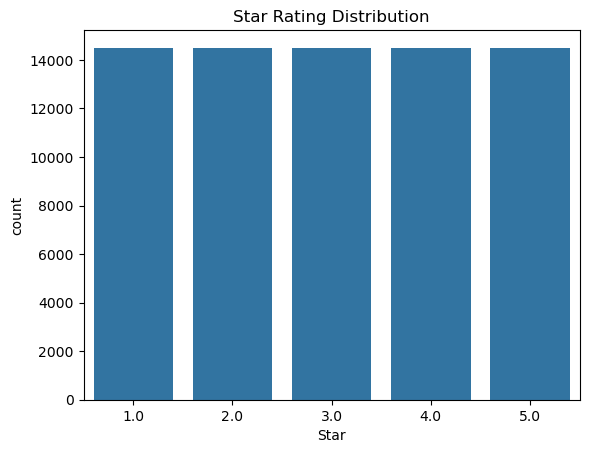

In [12]:
# Dataset Overview, the distribution of review stars
sns.countplot(x='Star', data=df)
plt.title('Star Rating Distribution')
plt.show()

This helps to verify the balance between classes (each star count should be equal in this dataset).

### Preprocessing

In [16]:
# Define stopwords manually (as NLTK is not allowed)
STOPWORDS = set(["the", "is", "and", "to", "this", "it", "of", "for", "in", "on", "a", "an", "that", "with", "as", "was", "are"])


In [18]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()
    return [word for word in tokens if word not in STOPWORDS]
# Function to clean and tokenize text by removing punctuation and stopwords

In [20]:
# Combine title and content, and apply cleaning
# This allows using both title and content fields as input text features.
df['combined'] = df['Title'].fillna('') + ' ' + df['Content'].fillna('')
df['tokens'] = df['combined'].apply(clean_text)

In [25]:
filtered_df = df[df['Star'] != 3].copy()  # <- .copy() burada önemli
filtered_df['label'] = filtered_df['Star'].apply(lambda x: 1 if x >= 4 else 0)

### Labeling

Convert review stars into binary sentiment labels: 1-2 → negative (0), 4-5 → positive (1), and exclude 3. This transformation simplifies the problem into a binary classification task (positive vs negative sentiment).


In [29]:
# Train-Test Split
train_data, test_data = train_test_split(filtered_df, test_size=0.2, stratify=filtered_df['label'], random_state=42)


In [31]:
# Bag of Words Class (Unigram & Bigram)
class BagOfWords:
    def __init__(self, ngram=1):
        self.ngram = ngram
        self.vocab = {}
        self.word_counts = {}

    def generate_ngrams(self, tokens):
        return [" ".join(tokens[i:i+self.ngram]) for i in range(len(tokens)-self.ngram+1)]

    def fit(self, texts):
        word_counter = Counter()
        for tokens in texts:
            ngrams = self.generate_ngrams(tokens)
            word_counter.update(ngrams)
        self.vocab = {word: idx for idx, (word, count) in enumerate(word_counter.items()) if count >= 2}


    def transform(self, texts):
        vectors = []
        max_idx = max(self.vocab.values()) + 1
        for tokens in texts:
            vec = np.zeros(max_idx)
            ngrams = self.generate_ngrams(tokens)
            for ngram in ngrams:
                idx = self.vocab.get(ngram)
                if idx is not None:
                    vec[idx] += 1
            vectors.append(vec)
        return np.array(vectors)

## Bag of Words Class

The `BagOfWords` class defined in this section is a custom implementation of a feature extraction technique widely used in text classification tasks. This class supports both **unigram**, **bigram**, or more generally, **n-gram** representations of text.

### Key Components:
- `ngram`: Determines the size of the n-gram (e.g., `1` for unigrams, `2` for bigrams).
- `vocab`: A dictionary that maps each observed n-gram to a unique index in the feature vector.
- `generate_ngrams()`: A helper method that slices a list of tokens into consecutive n-grams.
- `fit()`: Scans through all the input text samples, generates n-grams, and builds the vocabulary. To prevent noise, only n-grams that appear at least twice are included.
- `transform()`: Converts each tokenized input text into a fixed-length numerical vector by counting occurrences of n-grams found in the trained vocabulary.
- 
This class is the backbone of the feature extraction process. It transforms raw, tokenized text into structured numerical features that are essential for training the Naive Bayes classifier. By supporting different n-gram levels, it also enables experimentation with richer text representations for potentially better performance.


In [39]:
## 📊 10. Naive Bayes Classifier (From Scratch)
class NaiveBayes:
    def __init__(self):
        self.class_probs = {} # Stores the logarithmic prior probabilities of each class.
        self.word_probs = {} # Stores the logarithmic conditional probabilities of each feature (word/term) given the class.
        self.vocab_size = 0 # Tracks the size of the feature space (BoW vocabulary).

    def fit(self, X, y):
        self.vocab_size = X.shape[1]
        class_counts = np.bincount(y)
        total_samples = len(y)
        self.class_probs = {c: np.log(class_counts[c] / total_samples) for c in [0, 1]}

        word_counts = {0: np.ones(self.vocab_size), 1: np.ones(self.vocab_size)}  # Laplace smoothing
        for i, label in enumerate(y):
            word_counts[label] += X[i]

        total_words = {
            c: np.sum(word_counts[c]) for c in [0, 1]
        }

        self.word_probs = {
            c: np.log(word_counts[c] / total_words[c]) for c in [0, 1]
        }

    def predict(self, X):
        results = []
        for vec in X:
            scores = {}
            for c in [0, 1]:
                scores[c] = self.class_probs[c] + np.sum(vec * self.word_probs[c])
            results.append(max(scores, key=scores.get))
        return np.array(results)


## Naive Bayes Classifier

This section defines a fully custom implementation of a **Multinomial Naive Bayes** classifier, tailored for document classification tasks based on word frequency.

### Key Methods:
- `fit(X, y)`: 
  - Computes the **log prior probabilities** of each class using `log(P(c))`.
  - Calculates **log likelihoods** `log(P(w|c))` for each word using Laplace smoothing to handle zero-frequency issues.
  - Smoothing is achieved by initializing word counts with `1`, ensuring no zero probability.

- `predict(X)`:
  - For each document vector, it calculates the total log probability of each class.
  - The class with the higher log-probability score is chosen as the prediction.
  - It uses the **naive assumption** of feature independence and applies **log-space addition** for numerical stability.


- **Logarithmic computation** is used instead of direct multiplication to avoid numerical underflow in very long documents.
- **Laplace smoothing** ensures that unseen words in the training set do not cause the model to assign zero probability during testing.
- Works efficiently with the Bag of Words representation generated earlier.


## Train and Evaluate



In [46]:
# Unigram
bow_unigram = BagOfWords(ngram=1)
bow_unigram.fit(train_data['tokens'])
X_train_uni = bow_unigram.transform(train_data['tokens'])
X_test_uni = bow_unigram.transform(test_data['tokens'])

## Unigram Vectorization

We use the `BagOfWords` class with `ngram=1` to extract unigram features from the text.  
First, we build a vocabulary from the training data (`fit`), then convert both train and test texts into numerical vectors (`transform`).  
This prepares the data for the Naive Bayes classifier by turning each review into a vector of word counts.


In [50]:
nb_uni = NaiveBayes()
nb_uni.fit(X_train_uni, train_data['label'].values)
y_pred_uni = nb_uni.predict(X_test_uni)

We initialize the Naive Bayes classifier and train it using unigram feature vectors.  
Then, we predict sentiment labels on the test set.  
The model uses learned word probabilities and class priors to make predictions.


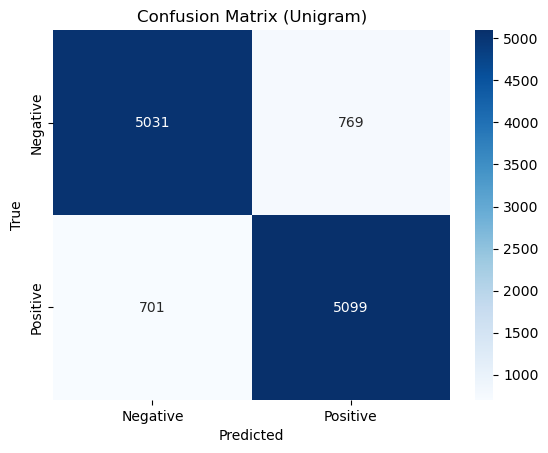

Unigram Model Performance:
Accuracy: 0.8732758620689656
Precision: 0.8689502385821404
Recall: 0.8791379310344828
F1-Score: 0.8740143983544738


In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
cm = confusion_matrix(test_data['label'], y_pred_uni)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Unigram)')
plt.show()
print("Unigram Model Performance:")
print("Accuracy:", accuracy_score(test_data['label'], y_pred_uni))
print("Precision:", precision_score(test_data['label'], y_pred_uni))
print("Recall:", recall_score(test_data['label'], y_pred_uni))
print("F1-Score:", f1_score(test_data['label'], y_pred_uni))

## BONUS: Word Embeddings + Logistic Regression

In [64]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression

In [66]:
# Train Word2Vec on tokens
w2v_model = Word2Vec(sentences=train_data['tokens'], vector_size=100, window=5, min_count=2, workers=4)


## Word2Vec Embedding

We train a Word2Vec model using the tokenized training data.  
Each review is represented as the **average vector** of the embeddings of its valid words.  
This allows capturing semantic relationships between words, unlike Bag of Words which only considers frequency.


In [69]:
def average_embedding(tokens):
    valid_tokens = [t for t in tokens if t in w2v_model.wv]
    if not valid_tokens:
        return np.zeros(100)
    return np.mean(w2v_model.wv[valid_tokens], axis=0)


This function converts a list of tokens into a single vector by averaging the Word2Vec embeddings of all valid words.  
If none of the tokens exist in the Word2Vec vocabulary, it returns a zero vector.  
This provides a fixed-size, dense representation for each review, capturing overall semantic meaning.

In [72]:
X_train_w2v = np.vstack(train_data['tokens'].apply(average_embedding))
X_test_w2v = np.vstack(test_data['tokens'].apply(average_embedding))
# Convert each review to a fixed-size vector using averaged Word2Vec embeddings.  
#`np.vstack` stacks them into a 2D input array.

In [77]:
clf = LogisticRegression()
clf.fit(X_train_w2v, train_data['label'])
y_pred_w2v = clf.predict(X_test_w2v)

## Training and Prediction with Logistic Regression

In this step, we train a `LogisticRegression` model using the averaged Word2Vec embeddings as input features.  
Logistic Regression is a commonly used linear classifier, especially effective when input features are dense and meaningful—as is the case with word embeddings.

Once the model is trained on the training set (`X_train_w2v`), we use it to predict sentiment labels on the test set (`X_test_w2v`).  
This allows us to evaluate how well semantic word vector representations contribute to the overall classification task compared to traditional methods like Bag of Words + Naive Bayes.


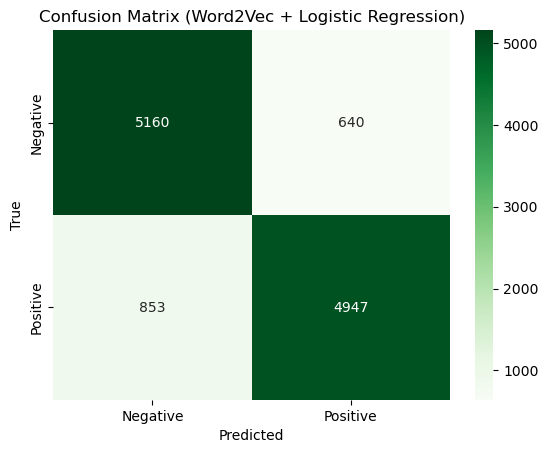


Bonus: Word2Vec + Logistic Regression Performance:
Accuracy: 0.8712931034482758
Precision: 0.8854483622695544
Recall: 0.8529310344827586
F1-Score: 0.8688855712654782


In [80]:
cm_bonus = confusion_matrix(test_data['label'], y_pred_w2v)
sns.heatmap(cm_bonus, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Word2Vec + Logistic Regression)')
plt.show()

print("\nBonus: Word2Vec + Logistic Regression Performance:")
print("Accuracy:", accuracy_score(test_data['label'], y_pred_w2v))
print("Precision:", precision_score(test_data['label'], y_pred_w2v))
print("Recall:", recall_score(test_data['label'], y_pred_w2v))
print("F1-Score:", f1_score(test_data['label'], y_pred_w2v))